# Authors
- Guijas Bravo, Pedro
- Miguélez Millos, Ángel

# 1. Initial setup

## Imports

In [ ]:
from collections import deque
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras import utils
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Mount Drive (HerMajestySpeechesDataset)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DS_FOLDER = "/content/drive/MyDrive/Inteligencia Artificial/Teoría/Q2.2/Modelado de Lenguaje/Prácticas/HerMajestySpeechesDataset"
DS_FOLDER = "/content/drive/MyDrive/HerMajestySpeechesDataset"

Mounted at /content/drive


## Download El Quijote

In [ ]:
!wget https://gist.githubusercontent.com/jsdario/6d6c69398cb0c73111e49f1218960f79/raw/8d4fc4548d437e2a7203a5aeeace5477f598827d/el_quijote.txt

def preprocess_and_split(file):
  with open(file) as f:
      lines = f.read()
  # Phrase per line
  lines = lines.replace(".",".\n")
  lines = lines.split("\n")

  # Split
  train_index = int(0.7*len(lines))
  dev_index = int(train_index + (len(lines)-train_index)/2)
  print(f"Train: {train_index} Dev/Test: {len(lines)-train_index}")

  with open('train.txt','w') as f:
    f.write("\n".join(lines[:train_index]))

  with open('dev.txt','w') as f:
    f.write("\n".join(lines[train_index:dev_index]))


  with open('test.txt','w') as f:
    f.write("\n".join(lines[dev_index:]))

  return (".")

DS_FOLDER_ALT = preprocess_and_split("el_quijote.txt")


--2023-04-29 09:16:52--  https://gist.githubusercontent.com/jsdario/6d6c69398cb0c73111e49f1218960f79/raw/8d4fc4548d437e2a7203a5aeeace5477f598827d/el_quijote.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1060259 (1.0M) [text/plain]
Saving to: ‘el_quijote.txt’

el_quijote.txt      100%[===================>]   1.01M  --.-KB/s    in 0.006s  

2023-04-29 09:16:53 (176 MB/s) - ‘el_quijote.txt’ saved [1060259/1060259]

Train: 4074 Dev/Test: 1747


# 2. Dataset and tokenizer

In [ ]:
class MyDataset:

  def __init__(self, debug=False):

    # Raw text from the corpus
    self.raw_train_ds, self.raw_dev_ds, self.raw_test_ds = None, None, None

    # Tokenized text
    self.train_ds, self.dev_ds, self.test_ds = None, None, None
    self.vocabulary_size = -1
    
    # Length of the sequences, only used when computing windows or padding (i.e. LSTM model)
    self.seq_length = -1  

    # End-of-sentence symbol
    self.end_token = '<end>'
    self.end_token_id = -1

    self.logger = logging.getLogger("MyDataset")
    self.logger.setLevel("DEBUG" if debug else "INFO")

  # ##############################
  # Load dataset
  # ##############################

  def _read_from_file(self, file):
    """
    Return the content of a file without empty lines. An special end-of-sentence
    token is added after every line. Empty lines are ignored.
    """
    if (not os.path.exists(file)):
      self.logger.error(f"File '{file}' not found!")
      return []

    with open(file, 'r') as f:
      return [line.replace("\n", f" {self.end_token}") for line in f.readlines() if line != '\n']

  def load_dataset(self, folder):
    """Load the train, dev and test datasets."""
    train_filename = os.path.join(folder, "train.txt")
    self.raw_train_ds = self._read_from_file(train_filename)

    dev_filename = os.path.join(folder, "dev.txt")
    self.raw_dev_ds = self._read_from_file(dev_filename)

    test_filename = os.path.join(folder, "test.txt")
    self.raw_test_ds = self._read_from_file(test_filename)

    self.logger.debug("* Some dataset statistics:")
    self.logger.debug(f"\tRaw train sentences: {len(self.raw_train_ds)}")
    self.logger.debug(f"\tRaw dev sentences: {len(self.raw_dev_ds)}")
    self.logger.debug(f"\tRaw test sentences: {len(self.raw_test_ds)}")

    self.logger.debug("* Some samples from the raw train dataset:")
    for sentence in self.raw_train_ds[0:10]:
      self.logger.debug(f"\t{sentence}")

  # ##############################
  # Preprocess dataset
  # ##############################

  def preprocess_dataset(self, tokenizer=None, num_words=None, compute_padded_windows=False, seq_length=10):
    """Apply a tokenizer to remove punctuation and convert the texts into ids sequences."""

    if (num_words is not None and num_words < 1):
      self.logger.error(f"The number of words to fit on must be positive! {num_words=}")
      return

    if (self.raw_train_ds is None):
      self.logger.error("Load the files dataset first!")
      return

    # Create our own tokenizer to preprocess the dataset
    if (tokenizer is None):
      filters = '!¡"#$%&()*+,-./:;=?¿@[\\]^_`{|}~\t\n'  # remove '<' and '>' to keep <end> token
      self.tokenizer = Tokenizer(num_words=num_words, oov_token="<unk>", filters=filters)
      self.tokenizer.fit_on_texts(self.raw_train_ds)
      self.end_token_id = self.encode_text([self.end_token])[0]

    # Tokenize the dataset into ids sequences
    self.train_ds = self.encode_texts(self.raw_train_ds)
    self.dev_ds = self.encode_texts(self.raw_dev_ds)
    self.test_ds = self.encode_texts(self.raw_test_ds)
    self.vocabulary_size = len(self.tokenizer.word_index)

    # Create sliding windows with padding of the given sentence length size (for LSTM model)
    if (compute_padded_windows):
      self.seq_length = seq_length

      self.train_ds = self._compute_sliding_windows(self.train_ds)
      self.dev_ds = self._compute_sliding_windows(self.dev_ds)
      self.test_ds = self._compute_sliding_windows(self.test_ds)

      # Pad the n-grams sequences to the sentence length.
      # Only the first n-grams of the sequences are padded since they are the
      # ones that lack context/previous words.
      self.train_ds = utils.pad_sequences(self.train_ds[0], maxlen=self.seq_length), self.train_ds[1]
      self.dev_ds = utils.pad_sequences(self.dev_ds[0], maxlen=self.seq_length), self.dev_ds[1]
      self.test_ds = utils.pad_sequences(self.test_ds[0], maxlen=self.seq_length), self.test_ds[1]

    self.logger.debug("* Some preprocessed samples from the train dataset:")
    if (type(self.train_ds) is tuple):
      for (input, target) in zip(self.train_ds[0][0:10], self.train_ds[1][0:10]):
        self.logger.debug(f"\t{input} -> {target}")
        self.logger.debug(f"\t{self.decode_sequence(input)} -> {self.decode_sequence([target])}")
    else:
      for sample in self.train_ds[0:10]:
        self.logger.debug(f"\t{sample}")
        self.logger.debug(f"\t{self.decode_sequence(sample)}")

  def _compute_sliding_windows(self, sequences):
    """Create inputs of sliding windows over each sequence and the next word as the target."""
    inputs = []
    targets = []

    for sequence in sequences:
        for i in range(len(sequence)):
            start = max(i - self.seq_length, 0)
            inputs.append(sequence[start:i])
            targets.append(sequence[i])

    return inputs, targets

  def batch(self, batch_size=32):
    """Create batches of samples."""
    if (type(self.train_ds) is not tuple):
      self.logger.error("Dataset must be in (input, target) format! (set compute_padded_windows=True when processing it)")

    self.train_ds = tf.data.Dataset.from_tensor_slices((self.train_ds[0], np.array(self.train_ds[1]))).batch(batch_size)
    self.dev_ds = tf.data.Dataset.from_tensor_slices((self.dev_ds[0], np.array(self.dev_ds[1]))).batch(batch_size)
    self.test_ds = tf.data.Dataset.from_tensor_slices((self.test_ds[0], np.array(self.test_ds[1]))).batch(batch_size)

  # ##############################
  # Encode texts and decode sequences
  # ##############################

  def encode_text(self, text):
    """Encode the text into a sequence of ids."""
    return self.tokenizer.texts_to_sequences([text])[0]

  def encode_texts(self, texts):
    """Encode texts into a sequences of ids."""
    return self.tokenizer.texts_to_sequences(texts)

  def decode_sequence(self, sequence):
    """Decode the ids sequence into text."""
    return self.tokenizer.sequences_to_texts([sequence])[0]

  def decode_sequences(self, sequences):
    """Decode a list of ids sequences into a list of texts."""
    return self.tokenizer.sequences_to_texts(sequences)

In [ ]:
dataset_queen = MyDataset(debug=True)
dataset_queen.load_dataset(DS_FOLDER)
dataset_queen.preprocess_dataset(tokenizer=None, num_words=None)

DEBUG:MyDataset:* Some dataset statistics:
DEBUG:MyDataset:	Raw train sentences: 2356
DEBUG:MyDataset:	Raw dev sentences: 565
DEBUG:MyDataset:	Raw test sentences: 490
DEBUG:MyDataset:* Some samples from the raw train dataset:
DEBUG:MyDataset:	The Queen's messages to those celebrating their 90th birthdays on 21 April <end>
DEBUG:MyDataset:	On this shared occasion, I send my warm congratulations to you all <end>
DEBUG:MyDataset:	Christmas Broadcast 2006 <end>
DEBUG:MyDataset:	The birth of a baby brings great happiness - but then the business of growing up begins. <end>
DEBUG:MyDataset:	The Queen's Christmas Broadcast in 2006 focused on understanding between faiths and generations. <end>
DEBUG:MyDataset:	The broadcast was filmed in Southwark Cathedral in London where Her Majesty met schoolchildren working on a Nativity collage. <end>
DEBUG:MyDataset:	I have lived long enough to know that things never remain quite the same for very long. <end>
DEBUG:MyDataset:	One of the things that has no

In [ ]:
dataset_quijote = MyDataset(debug=True)
dataset_quijote.load_dataset(DS_FOLDER_ALT)
dataset_quijote.preprocess_dataset(tokenizer=None, num_words=None)

DEBUG:MyDataset:* Some dataset statistics:
DEBUG:MyDataset:	Raw train sentences: 3178
DEBUG:MyDataset:	Raw dev sentences: 687
DEBUG:MyDataset:	Raw test sentences: 655
DEBUG:MyDataset:* Some samples from the raw train dataset:
DEBUG:MyDataset:	DON QUIJOTE DE LA MANCHA <end>
DEBUG:MyDataset:	Miguel de Cervantes Saavedra <end>
DEBUG:MyDataset:	PRIMERA PARTE <end>
DEBUG:MyDataset:	CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. <end>
DEBUG:MyDataset:	 Quijote de la Mancha <end>
DEBUG:MyDataset:	En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. <end>
DEBUG:MyDataset:	 Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. <end>
DEBUG:MyDataset:	 El resto della concluían sayo de velart

# 3. N-Gram

In [ ]:
class ToyLM_NGram:

  def __init__(self, debug=False):

    self.n = None  # context size

    # Dict that maps a pair (context, next_word) to counts representing the number
    # of times the next_word appears after the context in the training dataset.
    # Context is a tuple of 0 to n words.
    self.cooccurrences = {}

    self.logger = logging.getLogger("ToyML_NGram")
    self.logger.setLevel("DEBUG" if debug else "INFO")

  # ##############################
  # Compute co-occurrences table
  # ##############################

  def train(self, dataset, n=2):
    """Compute the co-occurrence table using n-grams with a context size of `n` words."""

    if (n < 1):
      self.logger.error(f"The context size must be positive! {n=}")
      return

    self.n = n
    self.cooccurrences = {}

    nseq = 0
    for sequence in tqdm(dataset):      
      context = deque([], maxlen=n)

      for next_word in sequence:
        occ = self.cooccurrences.get((tuple(context), next_word), 0)
        self.cooccurrences[(tuple(context), next_word)] = occ + 1
        context.append(next_word)

      if (nseq < 5):
        self.logger.debug(f"Sequence trained on: '{sequence}'")
        self.logger.debug(f"Table: {self.cooccurrences}")

      nseq += 1

    self.logger.debug(f"Computed co-occurrence table: {self.cooccurrences}")

  # ##############################
  # Generate predictions
  # ##############################

  def _cooccurrences_from_context(self, context):
    """Return the counts of the next words (ids) that matches the given `context`."""
    words = []
    counts = []

    for ((c, word), count) in self.cooccurrences.items():
      if (c == context):
        words.append(word)
        counts.append(count)

    return np.array(words), np.array(counts)

  def generate(self, sequence_length, tokenizer, initial_context="", mode="max", top=50):
    """
    Generate a sentence of maximum `sequence_length` words from an initial textual 
    context `context`. An object `tokenizer` of `MyDataset` class must be provided
    to encode the initial context and decode the results.

    If `mode="max"`, the next predicted word is the one with the highest probability.
    If `mode="distribution"`, the next predicted word is chosen from the 
    probability distribution of all the possible next words.
    If `mode="best_distribution"`, the same as the previous one but choosing only
    among the `top` most probable and possible words.
    """

    if (len(self.cooccurrences) == 0):
      self.logger.error("Must train and compute the co-occurrrence table before predicting!")
      return []

    context = tokenizer.encode_text(initial_context) if len(initial_context) > 0 else []
    predicted_sequence = context  # save the initial context to show on the final result too
    context = deque(context, maxlen=self.n)

    for _ in range(sequence_length):
      words, counts = self._cooccurrences_from_context(tuple(context))
      
      # Stop generating if the context is not present in the training dataset
      if (len(words) == 0):
        break

      if (mode == "max"):
        predicted_id = words[np.argmax(counts)]

      elif (mode in ("distribution", "best_distribution")):
        
        # Keep only the 'top' words by their count
        if (mode == "best_distribution"):
          best_counts_idx = list(reversed(np.argsort(counts)))[0:top]
          counts = counts[best_counts_idx]
          words = words[best_counts_idx]

        probs = counts / np.sum(counts)
        predicted_id = np.random.choice(words, p=probs)

      else:
        self.logger.error(f"Unsupported prediction mode '{mode}'!. Select one from: 'max', 'distribution' or 'best_distribution'")
        return []

      # Save the predicted id and update the context
      predicted_sequence.append(predicted_id)
      context.append(predicted_id)

      # Stop generating if an end-of-sentence symbol was predicted
      if (predicted_id == tokenizer.end_token_id):
        break

    return tokenizer.decode_sequence(predicted_sequence)

  # ##############################
  # Evaluate on test
  # ##############################

  def _smooth_probabilities(self, counts, vocabulary_size, alpha=1):
    """
    Apply Laplacian/Additive smoothing on the counts to enable unknown contexts.
    https://en.wikipedia.org/wiki/Additive_smoothing
    """
    # N = total number of counts of the words
    # d = number of different words
    denominator = np.sum(counts) + alpha * vocabulary_size  # N + α*d
    # x = number of counts of the current word (0 for unknowns)
    numerator = counts + alpha  # x + α
    return numerator / denominator

  def evaluate(self, dataset, vocabulary_size, alpha=1, max_seq_length=20):
    """Evaluate the perplexity on a given dataset. Sentences are truncated to `max_seq_length`."""
    perplexities = []

    for sequence in tqdm(dataset):
      perplexity = 1
      context = deque([], maxlen=self.n)

      len_sequence = min(len(sequence), max_seq_length)

      for current_id in sequence[0:len_sequence]:
        words, counts = self._cooccurrences_from_context(tuple(context))

        # If the context is unknown, add a single count of 0
        if (len(words) == 0):
          counts = np.append(counts, 0)
          current_id_idx = 0
        else:
          # Find the index of the current word through all the possible words
          try:
            current_id_idx = np.argwhere(words == current_id)
            current_id_idx = current_id_idx[0,0]
          except IndexError:  # word not matches with the current context
            counts = np.append(counts, 0)
            current_id_idx = -1

        smoothed_probs = self._smooth_probabilities(counts, vocabulary_size, alpha)
        prob = smoothed_probs[current_id_idx]
        perplexity *= prob

        context.append(current_id)

      perplexities.append(pow(perplexity, -1/len_sequence))

    return np.mean(perplexities)

### Queen

In [ ]:
# Create and train the model
ngram = ToyLM_NGram(debug=True)
ngram.train(dataset_queen.train_ds, n=2)

  0%|          | 0/2356 [00:00<?, ?it/s]DEBUG:ToyML_NGram:Sequence trained on: '[2, 182, 1000, 6, 40, 585, 42, 2095, 2096, 22, 1166, 531, 3]'
DEBUG:ToyML_NGram:Table: {((), 2): 1, ((2,), 182): 1, ((2, 182), 1000): 1, ((182, 1000), 6): 1, ((1000, 6), 40): 1, ((6, 40), 585): 1, ((40, 585), 42): 1, ((585, 42), 2095): 1, ((42, 2095), 2096): 1, ((2095, 2096), 22): 1, ((2096, 22), 1166): 1, ((22, 1166), 531): 1, ((1166, 531), 3): 1}
DEBUG:ToyML_NGram:Sequence trained on: '[22, 10, 164, 247, 9, 1001, 26, 425, 1167, 6, 19, 21, 3]'
DEBUG:ToyML_NGram:Table: {((), 2): 1, ((2,), 182): 1, ((2, 182), 1000): 1, ((182, 1000), 6): 1, ((1000, 6), 40): 1, ((6, 40), 585): 1, ((40, 585), 42): 1, ((585, 42), 2095): 1, ((42, 2095), 2096): 1, ((2095, 2096), 22): 1, ((2096, 22), 1166): 1, ((22, 1166), 531): 1, ((1166, 531), 3): 1, ((), 22): 1, ((22,), 10): 1, ((22, 10), 164): 1, ((10, 164), 247): 1, ((164, 247), 9): 1, ((247, 9), 1001): 1, ((9, 1001), 26): 1, ((1001, 26), 425): 1, ((26, 425), 1167): 1, ((425, 

In [ ]:
# Evaluate
print(ngram.evaluate(dataset_queen.test_ds, dataset_queen.vocabulary_size, alpha=0.001))
print(ngram.evaluate(dataset_queen.test_ds, dataset_queen.vocabulary_size, alpha=0.01))
print(ngram.evaluate(dataset_queen.test_ds, dataset_queen.vocabulary_size, alpha=0.1))
print(ngram.evaluate(dataset_queen.test_ds, dataset_queen.vocabulary_size, max_seq_length=100, alpha=0.01))

100%|██████████| 490/490 [00:22<00:00, 21.73it/s]


2692.418608864748


100%|██████████| 490/490 [00:24<00:00, 20.36it/s]


2205.3354414502246


100%|██████████| 490/490 [00:24<00:00, 20.23it/s]


2521.9458366658114


100%|██████████| 490/490 [00:33<00:00, 14.60it/s]

2214.5463584953986


In [ ]:
# Generate text
print(ngram.generate(25, dataset_queen, initial_context="", mode="max"))
print(ngram.generate(25, dataset_queen, initial_context="i am", mode="max"))
print(ngram.generate(50, dataset_queen, initial_context="i am not", mode="max"))  # loop problem 
print(ngram.generate(25, dataset_queen, initial_context="war", mode="max"))  # sparsity problem (no sentence starting with 'war')

print(ngram.generate(30, dataset_queen, initial_context="", mode="distribution"))
print(ngram.generate(30, dataset_queen, initial_context="", mode="distribution"))
print(ngram.generate(30, dataset_queen, initial_context="", mode="best_distribution", top=10))
print(ngram.generate(30, dataset_queen, initial_context="", mode="best_distribution", top=50))

i am pleased to be back in australia and all those who have been affected by yesterday's awful violence <end>
i am pleased to be back in australia and all those who have been affected by yesterday's awful violence <end>
i am not alone in thinking it so during my lifetime has firmly established itself amongst the most important contact between nations is usually contact between nations is usually contact between nations is usually contact between nations is usually contact between nations is usually contact between nations is usually contact between nations is
war
and each of st lucia for this country is immune from these dangers and we do well to remember in peace <end>
the loss united by an extraordinary record for a break from work for peace and the deployment of new zealand is known by the queen <end>
and this building to add that this confidence and engagement of canadians everywhere <end>
in april the commonwealth is not just royal visits that regional newspapers cover <end>


In [ ]:
# Different seq len
ngram = ToyLM_NGram(debug=False)
ngram.train(dataset_queen.train_ds, n=4)
print(ngram.evaluate(dataset_queen.test_ds, dataset_queen.vocabulary_size, alpha=0.01))
ngram.train(dataset_queen.train_ds, n=8)
print(ngram.evaluate(dataset_queen.test_ds, dataset_queen.vocabulary_size, alpha=0.01))


100%|██████████| 490/490 [00:26<00:00, 18.32it/s]


3539.6676561367212


100%|██████████| 490/490 [00:28<00:00, 17.42it/s]

3801.132524038454


### Quijote

In [ ]:
# Create and train the model
ngram = ToyLM_NGram(debug=True)
ngram.train(dataset_quijote.train_ds, n=2)

  0%|          | 0/3178 [00:00<?, ?it/s]DEBUG:ToyML_NGram:Sequence trained on: '[22, 30, 3, 5, 433, 7]'
DEBUG:ToyML_NGram:Table: {((), 22): 1, ((22,), 30): 1, ((22, 30), 3): 1, ((30, 3), 5): 1, ((3, 5), 433): 1, ((5, 433), 7): 1}
DEBUG:ToyML_NGram:Sequence trained on: '[3817, 3, 2919, 5624, 7]'
DEBUG:ToyML_NGram:Table: {((), 22): 1, ((22,), 30): 1, ((22, 30), 3): 1, ((30, 3), 5): 1, ((3, 5), 433): 1, ((5, 433), 7): 1, ((), 3817): 1, ((3817,), 3): 1, ((3817, 3), 2919): 1, ((3, 2919), 5624): 1, ((2919, 5624), 7): 1}
DEBUG:ToyML_NGram:Sequence trained on: '[498, 115, 7]'
DEBUG:ToyML_NGram:Table: {((), 22): 1, ((22,), 30): 1, ((22, 30), 3): 1, ((30, 3), 5): 1, ((3, 5), 433): 1, ((5, 433), 7): 1, ((), 3817): 1, ((3817,), 3): 1, ((3817, 3), 2919): 1, ((3, 2919), 5624): 1, ((2919, 5624), 7): 1, ((), 498): 1, ((498,), 115): 1, ((498, 115), 7): 1}
DEBUG:ToyML_NGram:Sequence trained on: '[337, 5625, 2, 837, 3, 5, 583, 4, 1031, 20, 383, 741, 893, 7]'
DEBUG:ToyML_NGram:Table: {((), 22): 1, ((22,),

In [ ]:
# Evaluate
print(ngram.evaluate(dataset_quijote.test_ds, dataset_quijote.vocabulary_size, alpha=0.001))
print(ngram.evaluate(dataset_quijote.test_ds, dataset_quijote.vocabulary_size, alpha=0.01))
print(ngram.evaluate(dataset_quijote.test_ds, dataset_quijote.vocabulary_size, alpha=0.1))
print(ngram.evaluate(dataset_quijote.test_ds, dataset_quijote.vocabulary_size, max_seq_length=100, alpha=0.01))

100%|██████████| 655/655 [01:18<00:00,  8.34it/s]


6632.415937982611


100%|██████████| 655/655 [01:16<00:00,  8.61it/s]


4982.409340274907


100%|██████████| 655/655 [01:16<00:00,  8.52it/s]


5437.9251447945735


  0%|          | 2/655 [00:00<02:53,  3.76it/s]<ipython-input-12-a89de72f69a3>:166: RuntimeWarning: divide by zero encountered in double_scalars
  perplexities.append(pow(perplexity, -1/len_sequence))
100%|██████████| 655/655 [02:58<00:00,  3.67it/s]

inf


In [ ]:
# Generate text
print(ngram.generate(25, dataset_quijote, initial_context="", mode="max"))
print(ngram.generate(25, dataset_quijote, initial_context="Yo soy el ", mode="max"))
print(ngram.generate(50, dataset_quijote, initial_context="Me apetece comerme un", mode="max"))
print(ngram.generate(25, dataset_quijote, initial_context="Sancho", mode="max"))

print(ngram.generate(30, dataset_quijote, initial_context="", mode="distribution"))
print(ngram.generate(30, dataset_quijote, initial_context="", mode="distribution"))
print(ngram.generate(30, dataset_quijote, initial_context="", mode="best_distribution", top=10))
print(ngram.generate(30, dataset_quijote, initial_context="", mode="best_distribution", top=50))

y así como el de la mancha <end>
yo soy el que no se le había dado a aquel punto no saliera el ventero que vió a las manos y dió con ella que era un
me <unk> <unk> un
sancho panza que doquiera que vía asnos se le había dado a aquel punto no saliera el ventero que vió a las manos y dió con
sancho llegó a sus leyes y los notes retirémonos a aquel ni me viene gana de ver la figura de saber que con él en tierra y a no sentir
yo soy cuyo deseo a lo hondo de mi espada <end>
en lo que a él el escudero se alongó un buen golpe y tras él a solas <end>
quijote podrán servir de escondida sepultura a un jimio <end>


In [ ]:
# Different seq len
ngram = ToyLM_NGram(debug=False)
ngram.train(dataset_quijote.train_ds, n=4)
print(ngram.evaluate(dataset_queen.test_ds, dataset_queen.vocabulary_size, alpha=0.01))
ngram.train(dataset_queen.train_ds, n=8)
print(ngram.evaluate(dataset_queen.test_ds, dataset_queen.vocabulary_size, alpha=0.01))

100%|██████████| 490/490 [01:09<00:00,  7.09it/s]


5393.7454995777425


100%|██████████| 490/490 [00:28<00:00, 16.95it/s]

3801.132524038454


# 4. LSTM

In [ ]:
class ToyLM_LSTM:

  def __init__(self, debug=False):

    self.input_seq_length = -1  # context size

    self.logger = logging.getLogger("ToyML_LSTM")
    self.logger.setLevel("DEBUG" if debug else "INFO")

  # ##############################
  # Create and train the model
  # ##############################

  def create_model(self, vocabulary_size, input_seq_length, embedding_size=20, lstm_neurons=64):
    """Create an embedding-LSTM model."""
    self.input_seq_length = input_seq_length

    self.model = keras.Sequential(name=self.__class__.__name__)
    self.model.add(layers.Embedding(vocabulary_size + 1, embedding_size, input_length=self.input_seq_length, mask_zero=True, name="Embedding"))  # +1 for padding
    self.model.add(layers.LSTM(lstm_neurons, name="LSTM"))
    self.model.add(layers.Dense(vocabulary_size + 1, name="Dense"))
    self.model.add(layers.Activation('softmax', name="Softmax"))
    
    self.model.summary()

  def train(self, train_dataset, dev_dataset=None, epochs=10, learning_rate=0.01, stopping_metric="val_loss", patience=5, metrics=["accuracy"]):
    """Train the model on the training dataset."""

    # Compile the model
    self.model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=optimizers.Adam(learning_rate), 
        metrics=metrics
    )

    # Train the model
    early_stopping = EarlyStopping(monitor=stopping_metric, patience=patience)
    self.history = self.model.fit(train_dataset, epochs=epochs, validation_data=dev_dataset, callbacks=[early_stopping])
    
  def plot_history(self, metrics=["loss", "accuracy"]):
    """Plot the training loss and `metrics` history."""
    
    if (self.history is None):
      self.logger.error("Train the model first!")
      return

    for metric in metrics:
      plt.plot(self.history.history[metric])
      plt.plot(self.history.history["val_"+metric])
      plt.title(metric.capitalize())
      plt.ylabel(metric)
      plt.xlabel("epoch")
      plt.legend(["train", "val"], loc='upper left')
      plt.show()
    
  # ##############################
  # Generate predictions
  # ##############################

  def generate(self, sequence_length, tokenizer, initial_context="", mode="max", top=50):
    """
    Generate a sentence of maximum `sequence_length` words from an initial textual 
    context `context`.

    If `mode="max"`, the next predicted word is the one with the highest probability.
    If `mode="distribution"`, the next predicted word is chosen from the 
    probability distribution of all the possible next words.
    If `mode="best_distribution"`, the same as the previous one but choosing only
    among the `top` most probable and possible words.
    """

    if (self.model is None):
      self.logger.error("Must train the model before predicting!")
      return []

    context = tokenizer.encode_text(initial_context) if len(initial_context) > 0 else []
    predicted_sequence = context

    # pad_sequences() requires a list of lists, so we enclose the context inside a
    # list and then retrieve the first element of the padded sequences
    context = utils.pad_sequences([context], maxlen=self.input_seq_length)[0]

    context = deque(context, maxlen=self.input_seq_length)

    for _ in range(sequence_length):

      input = np.reshape(context, (1, self.input_seq_length))
      outputs = self.model.predict(input, verbose=0)[0]  # [0] to remove the batch dimension

      if (mode == "max"):
        predicted_id = np.argmax(outputs)

      elif (mode == "distribution"):
        ids = list(range(outputs.size))
        predicted_id = np.random.choice(ids, p=outputs)

      elif (mode == "best_distribution"):
        best_ids = list(reversed(np.argsort(outputs)))[0:top]
        best_outputs = outputs[best_ids]
        best_outputs /= np.sum(best_outputs) # normalize so they sum up to 1
        predicted_id = np.random.choice(best_ids, p=best_outputs)

      else:
        self.logger.error(f"Unsupported prediction mode '{mode}'!. Select one from: 'max', 'distribution' or 'best_distribution'")
        return []

      # Save the predicted id and update the context
      predicted_sequence.append(predicted_id)
      context.append(predicted_id)

      # Stop generating if an end-of-sentence symbol was generated
      if (predicted_id == tokenizer.end_token_id):
        break

    return tokenizer.decode_sequence(predicted_sequence)

  # ##############################
  # Evaluate on test
  # ##############################

  def _smooth_probabilities(self, probs, alpha=1):
    num_words = len(probs)
    n = np.sum(probs)  # n=1 if the LSTM uses a softmax
    return (probs + alpha) / (n + alpha * num_words)

  def evaluate(self, dataset, end_token_id, max_seq_length=20, alpha=1):
    """Evaluate the model on a given dataset."""

    if (self.model is None):
      self.logger.error("Create the model first!")
      return

    perplexities = []
    perplexity = 1
    word_count = 0

    for batch in tqdm(dataset):
      probs = self.model.predict(batch[0], verbose=0)
        
      # Get the probabilities of the real words for all the batch
      for probs, real_output in zip(probs, batch[1]):
        probs = self._smooth_probabilities(probs, alpha=alpha)
        word_count += 1
        if (word_count < max_seq_length):
          perplexity *= probs[real_output]

          if (real_output == end_token_id):
            perplexities.append((perplexity, word_count))
            perplexity = 1
            word_count = 0

        # Ignore the rest of words until reaching the end of the sentence
        else:
            if (real_output == end_token_id):
              perplexities.append((perplexity, word_count))
              perplexity = 1
              word_count = 0         
      
    self.logger.debug(f"\nProb terms by phrase = {perplexities}")

    # Compute perplexities
    perplexities = [pow(prod, -1/n) for prod, n in perplexities]

    self.logger.debug(f"\nPerplexities by phrase = {perplexities}")
    if (self.logger.isEnabledFor(logging.DEBUG)):
      plt.hist(perplexities, bins=50)
      plt.show()

    return np.mean(perplexities)

### Queen

In [ ]:
# Rebuild the dataset (preprocesint it)
dataset_queen = MyDataset(debug=True)
dataset_queen.load_dataset(DS_FOLDER)
dataset_queen.preprocess_dataset(tokenizer=None, num_words=None, compute_padded_windows=True, seq_length=10)
dataset_queen.batch(32)

DEBUG:MyDataset:* Some dataset statistics:
DEBUG:MyDataset:	Raw train sentences: 2356
DEBUG:MyDataset:	Raw dev sentences: 565
DEBUG:MyDataset:	Raw test sentences: 490
DEBUG:MyDataset:* Some samples from the raw train dataset:
DEBUG:MyDataset:	The Queen's messages to those celebrating their 90th birthdays on 21 April <end>
DEBUG:MyDataset:	On this shared occasion, I send my warm congratulations to you all <end>
DEBUG:MyDataset:	Christmas Broadcast 2006 <end>
DEBUG:MyDataset:	The birth of a baby brings great happiness - but then the business of growing up begins. <end>
DEBUG:MyDataset:	The Queen's Christmas Broadcast in 2006 focused on understanding between faiths and generations. <end>
DEBUG:MyDataset:	The broadcast was filmed in Southwark Cathedral in London where Her Majesty met schoolchildren working on a Nativity collage. <end>
DEBUG:MyDataset:	I have lived long enough to know that things never remain quite the same for very long. <end>
DEBUG:MyDataset:	One of the things that has no

Model: "ToyLM_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 10, 20)            112320    
                                                                 
 LSTM (LSTM)                 (None, 64)                21760     
                                                                 
 Dense (Dense)               (None, 5616)              365040    
                                                                 
 Softmax (Activation)        (None, 5616)              0         
                                                                 
Total params: 499,120
Trainable params: 499,120
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1722/1722 [==============================] - 74s 40ms/step - loss: 6.2609 - accuracy: 0.1127 - val_loss: 6.0698 - val_accuracy: 0.1453
Epoch 2/20
1722/1722 [==============

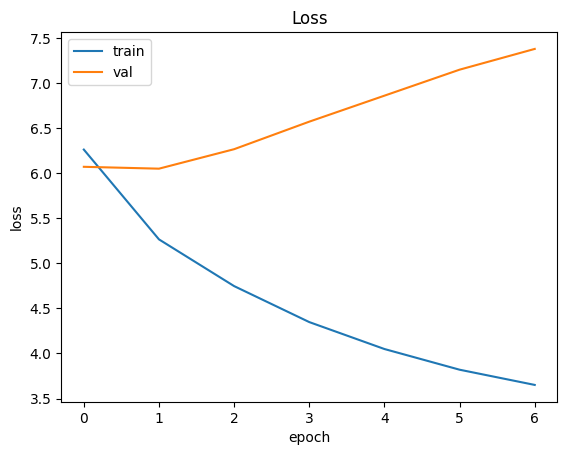

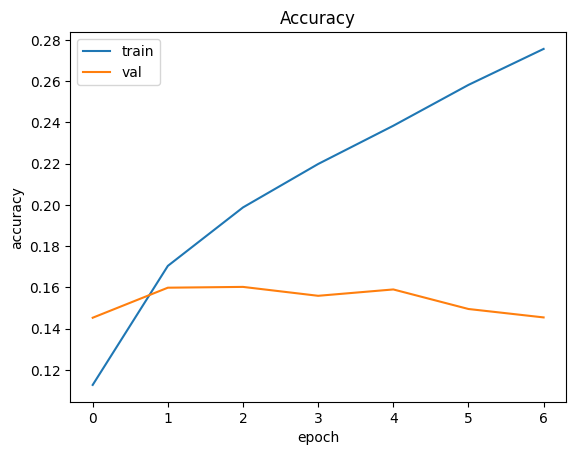

In [ ]:
# Create and train the model
lstm = ToyLM_LSTM(debug=False)
lstm.create_model(input_seq_length=10, vocabulary_size=dataset_queen.vocabulary_size, embedding_size=20, lstm_neurons=64)
lstm.train(dataset_queen.train_ds, dev_dataset=dataset_queen.dev_ds, epochs=20, learning_rate=0.01)
lstm.plot_history()

In [ ]:
# Evaluate
print(lstm.evaluate(dataset_queen.test_ds, dataset_queen.end_token_id, max_seq_length=20, alpha=0.))
print(lstm.evaluate(dataset_queen.test_ds, dataset_queen.end_token_id, max_seq_length=20, alpha=0.0001))
print(lstm.evaluate(dataset_queen.test_ds, dataset_queen.end_token_id, max_seq_length=20, alpha=0.0005))
print(lstm.evaluate(dataset_queen.test_ds, dataset_queen.end_token_id, max_seq_length=100, alpha=0.0001))

100%|██████████| 373/373 [00:32<00:00, 11.47it/s]


27588.92796858441


100%|██████████| 373/373 [00:30<00:00, 12.28it/s]


318.29822478235985


100%|██████████| 373/373 [00:32<00:00, 11.62it/s]


369.5742368701468


100%|██████████| 373/373 [00:40<00:00,  9.11it/s]

522.1233663086426


In [ ]:
# Generate text
print(lstm.generate(25, dataset_queen, initial_context="", mode="max"))
print(lstm.generate(25, dataset_queen, initial_context="i am", mode="max"))
print(lstm.generate(50, dataset_queen, initial_context="i am not", mode="max"))
print(lstm.generate(25, dataset_queen, initial_context="war", mode="max"))
print(lstm.generate(30, dataset_queen, initial_context="", mode="distribution"))
print(lstm.generate(30, dataset_queen, initial_context="", mode="distribution"))
print(lstm.generate(30, dataset_queen, initial_context="", mode="best_distribution", top=10))
print(lstm.generate(30, dataset_queen, initial_context="", mode="best_distribution", top=50))

i am speaking to be able to take it <end>
i am speaking to be able to take it <end>
i am not writers from this opportunity to speak here today <end>
war and encouragement <end>
collectively the potential to those nigeria as you serve members in his 60th threat of society <end>
i am thinking grateful to see in those who died in the coming and the faith to person and so many that year we meeting some and old ones in
this parliament can be expected that this year <end>
as queen of the last year by the world of canada <end>


In [ ]:
# Different seq lenghts (4)

# DS
dataset_queen = MyDataset(debug=False)
dataset_queen.load_dataset(DS_FOLDER)
dataset_queen.preprocess_dataset(tokenizer=None, num_words=None, compute_padded_windows=True, seq_length=4)
dataset_queen.batch(32)

# Model
lstm = ToyLM_LSTM(debug=False)
lstm.create_model(input_seq_length=4, vocabulary_size=dataset_queen.vocabulary_size, embedding_size=20, lstm_neurons=64)
lstm.train(dataset_queen.train_ds, dev_dataset=dataset_queen.dev_ds, epochs=20, learning_rate=0.01)
print(lstm.evaluate(dataset_queen.test_ds, dataset_queen.end_token_id, max_seq_length=20, alpha=0.0001))

Model: "ToyLM_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 4, 20)             112320    
                                                                 
 LSTM (LSTM)                 (None, 64)                21760     
                                                                 
 Dense (Dense)               (None, 5616)              365040    
                                                                 
 Softmax (Activation)        (None, 5616)              0         
                                                                 
Total params: 499,120
Trainable params: 499,120
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1722/1722 [==============================] - 43s 23ms/step - loss: 6.2219 - accuracy: 0.1156 - val_loss: 6.0251 - val_accuracy: 0.1502
Epoch 2/20
1722/1722 [==============

100%|██████████| 373/373 [00:34<00:00, 10.90it/s]

318.0221522197891


### Quijote

In [ ]:
# Rebuild the dataset (preprocesint it)
dataset_quijote = MyDataset(debug=True)
dataset_quijote.load_dataset(DS_FOLDER_ALT)
dataset_quijote.preprocess_dataset(tokenizer=None, num_words=None, compute_padded_windows=True, seq_length=10)
dataset_quijote.batch(32)

DEBUG:MyDataset:* Some dataset statistics:
DEBUG:MyDataset:	Raw train sentences: 3178
DEBUG:MyDataset:	Raw dev sentences: 687
DEBUG:MyDataset:	Raw test sentences: 655
DEBUG:MyDataset:* Some samples from the raw train dataset:
DEBUG:MyDataset:	DON QUIJOTE DE LA MANCHA <end>
DEBUG:MyDataset:	Miguel de Cervantes Saavedra <end>
DEBUG:MyDataset:	PRIMERA PARTE <end>
DEBUG:MyDataset:	CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. <end>
DEBUG:MyDataset:	 Quijote de la Mancha <end>
DEBUG:MyDataset:	En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. <end>
DEBUG:MyDataset:	 Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. <end>
DEBUG:MyDataset:	 El resto della concluían sayo de velart

Model: "ToyLM_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 10, 20)            237320    
                                                                 
 LSTM (LSTM)                 (None, 64)                21760     
                                                                 
 Dense (Dense)               (None, 11866)             771290    
                                                                 
 Softmax (Activation)        (None, 11866)             0         
                                                                 
Total params: 1,030,370
Trainable params: 1,030,370
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
4197/4197 [==============================] - 142s 31ms/step - loss: 6.2483 - accuracy: 0.0916 - val_loss: 6.3220 - val_accuracy: 0.0994
Epoch 2/20
4197/4197 [=========

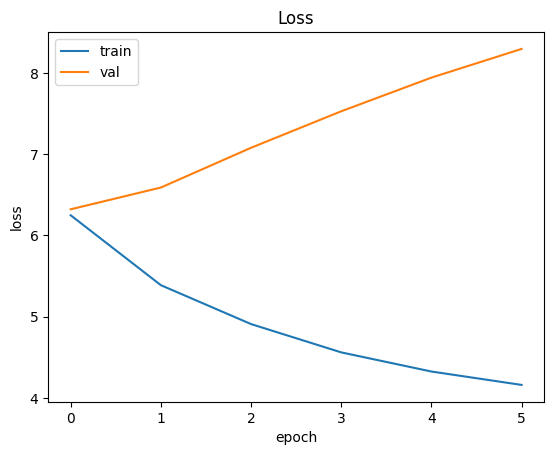

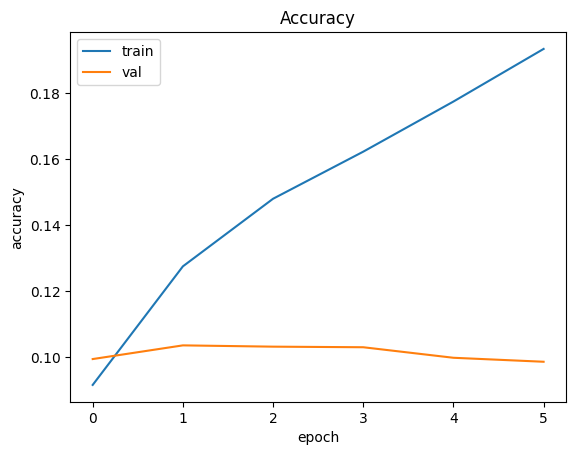

In [ ]:
lstm = ToyLM_LSTM(debug=False)
lstm.create_model(input_seq_length=10, vocabulary_size=dataset_quijote.vocabulary_size, embedding_size=20, lstm_neurons=64)
lstm.train(dataset_quijote.train_ds, dev_dataset=dataset_quijote.dev_ds, epochs=20, learning_rate=0.01)
lstm.plot_history()

In [ ]:
# Evaluate
print(lstm.evaluate(dataset_quijote.test_ds, dataset_quijote.end_token_id, max_seq_length=20, alpha=0.))
print(lstm.evaluate(dataset_quijote.test_ds, dataset_quijote.end_token_id, max_seq_length=20, alpha=0.0001))
print(lstm.evaluate(dataset_quijote.test_ds, dataset_quijote.end_token_id, max_seq_length=20, alpha=0.0005))
print(lstm.evaluate(dataset_quijote.test_ds, dataset_quijote.end_token_id, max_seq_length=100, alpha=0.0001))

100%|██████████| 909/909 [01:11<00:00, 12.66it/s]


109581.29715720995


100%|██████████| 909/909 [01:09<00:00, 13.09it/s]


287.50230083774056


100%|██████████| 909/909 [01:21<00:00, 11.10it/s]


467.94408246511557


100%|██████████| 909/909 [01:13<00:00, 12.40it/s]

inf



<ipython-input-7-cf0f6cb0a6b8>:162: RuntimeWarning: divide by zero encountered in double_scalars
  perplexities = [pow(prod, -1/n) for prod, n in perplexities]


In [ ]:
print(lstm.generate(25, dataset_quijote, initial_context="", mode="max"))
print(lstm.generate(25, dataset_quijote, initial_context="Yo soy el ", mode="max"))
print(lstm.generate(50, dataset_quijote, initial_context="Me apetece comerme un", mode="max"))
print(lstm.generate(25, dataset_quijote, initial_context="Sancho", mode="max"))
print(lstm.generate(30, dataset_quijote, initial_context="", mode="distribution"))
print(lstm.generate(30, dataset_quijote, initial_context="", mode="distribution"))
print(lstm.generate(30, dataset_quijote, initial_context="", mode="best_distribution", top=10))
print(lstm.generate(30, dataset_quijote, initial_context="", mode="best_distribution", top=50))

y que si no hay ladrón de la cual dijo <end>
yo soy el traidor dijo don quijote <end>
me <unk> <unk> un gigantillo de la venta de la venta principalmente de su casa y que la vista y que no lo diré que no lo pudo y que si no me ha de ser por la cual dijo <end>
sancho panza que no se ha hecho de su amante y monja de don quijote y que si no se ha venido a ser por la
tañía anselmo que don quijote supiera perdóname y en esta mitad de y lanzón que le dijo el cura mismo mozo llamado vuestro caballero donde se acomodaron de mambrino panza
halló en efeto mayor sangre <end>
mas por esto y que no lo quiero echar que se vestía permitas <end>
y dijo el cura aunque que la dijo sancho sino haber en el de la princesa que dijo don quijote y esperó al cabo de su buena pieza donde cubría


In [ ]:
# Different seq lenghts (4)

# DS
dataset_quijote = MyDataset(debug=False)
dataset_quijote.load_dataset(DS_FOLDER_ALT)
dataset_quijote.preprocess_dataset(tokenizer=None, num_words=None, compute_padded_windows=True, seq_length=4)
dataset_quijote.batch(32)

# Model
lstm = ToyLM_LSTM(debug=False)
lstm.create_model(input_seq_length=4, vocabulary_size=dataset_quijote.vocabulary_size, embedding_size=20, lstm_neurons=64)
lstm.train(dataset_quijote.train_ds, dev_dataset=dataset_quijote.dev_ds, epochs=20, learning_rate=0.01)
print(lstm.evaluate(dataset_quijote.test_ds, dataset_quijote.end_token_id, max_seq_length=20, alpha=0.0001))

Model: "ToyLM_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 4, 20)             237320    
                                                                 
 LSTM (LSTM)                 (None, 64)                21760     
                                                                 
 Dense (Dense)               (None, 11866)             771290    
                                                                 
 Softmax (Activation)        (None, 11866)             0         
                                                                 
Total params: 1,030,370
Trainable params: 1,030,370
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
4197/4197 [==============================] - 80s 18ms/step - loss: 6.2319 - accuracy: 0.0932 - val_loss: 6.3203 - val_accuracy: 0.0988
Epoch 2/20
4197/4197 [==========

100%|██████████| 909/909 [01:23<00:00, 10.85it/s]

310.5636136766341
